In [1]:
import copy
from collections import deque
import random
import matplotlib.pyplot as plt
import numpy as np
import gym
from dezero import Model
from dezero import optimizers
import dezero.functions as F
import dezero.layers as L

In [2]:
class ReplayBuffer:
    def __init__(self, buffer_size, batch_size):
        self.buffer = deque(maxlen=buffer_size)
        self.batch_size = batch_size

    def add(self, state, action, reward, next_state, done):
        data = (state, action, reward, next_state, done)
        self.buffer.append(data)

    def __len__(self):
        return len(self.buffer)

    def get_batch(self):
        data = random.sample(self.buffer, self.batch_size)

        state = np.stack([x[0] for x in data])
        action = np.array([x[1] for x in data])
        reward = np.array([x[2] for x in data])
        next_state = np.stack([x[3] for x in data])
        done = np.array([x[4] for x in data]).astype(np.int32)
        return state, action, reward, next_state, done

In [3]:
class QNet(Model):  # 신경망 클래스
    def __init__(self, action_size):
        super().__init__()
        self.l1 = L.Linear(128)
        self.l2 = L.Linear(128)
        self.l3 = L.Linear(action_size)

    def forward(self, x):
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = self.l3(x)
        return x

In [4]:
class DQNAgent:  # 에이전트 클래스
    def __init__(self):
        self.gamma = 0.98
        self.lr = 0.0005
        self.epsilon = 0.1
        self.buffer_size = 10000  # 경험 재생 버퍼 크기
        self.batch_size = 32      # 미니배치 크기
        self.action_size = 2

        self.replay_buffer = ReplayBuffer(self.buffer_size, self.batch_size)
        self.qnet = QNet(self.action_size)         # 원본 신경망
        self.qnet_target = QNet(self.action_size)  # 목표 신경망
        self.optimizer = optimizers.Adam(self.lr)
        self.optimizer.setup(self.qnet)            # 옵티마이저에 qnet 등록

    def get_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.action_size)
        else:
            state = state[np.newaxis, :]  # 배치 처리용 차원 추가
            qs = self.qnet(state)
            return qs.data.argmax()

    def update(self, state, action, reward, next_state, done):
        # 경험 재생 버퍼에 경험 데이터 추가
        self.replay_buffer.add(state, action, reward, next_state, done)
        if len(self.replay_buffer) < self.batch_size:
            return  # 데이터가 미니배치 크기만큼 쌓이지 않았다면 여기서 끝

        # 미니배치 크기 이상이 쌓이면 미니배치 생성
        state, action, reward, next_state, done = self.replay_buffer.get_batch()
        qs = self.qnet(state)
        q = qs[np.arange(self.batch_size), action]

        next_qs = self.qnet_target(next_state)
        next_q = next_qs.max(axis=1)
        next_q.unchain()
        target = reward + (1 - done) * self.gamma * next_q

        loss = F.mean_squared_error(q, target)

        self.qnet.cleargrads()
        loss.backward()
        self.optimizer.update()

    def sync_qnet(self):  # 두 신경망 동기화
        self.qnet_target = copy.deepcopy(self.qnet)

In [6]:
episodes = 300      # 에피소드 수
sync_interval = 20  # 신경망 동기화 주기(20번째 에피소드마다 동기화)
env = gym.make('CartPole-v0', render_mode='rgb_array')
agent = DQNAgent()
reward_history = [] # 에피소드별 보상 기록

In [7]:
for episode in range(episodes):
    state = env.reset()[0]
    done = False
    total_reward = 0

    while not done:
        action = agent.get_action(state)
        next_state, reward, terminated, truncated, info = env.step(action)
        done = terminated | truncated

        agent.update(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward

    if episode % sync_interval == 0:
        agent.sync_qnet()

    reward_history.append(total_reward)
    if episode % 10 == 0:
        print("episode :{}, total reward : {}".format(episode, total_reward))

C:\Users\ljy25\anaconda3\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


episode :0, total reward : 11.0
episode :10, total reward : 8.0
episode :20, total reward : 11.0
episode :30, total reward : 10.0
episode :40, total reward : 10.0
episode :50, total reward : 11.0
episode :60, total reward : 9.0
episode :70, total reward : 10.0
episode :80, total reward : 10.0
episode :90, total reward : 10.0
episode :100, total reward : 9.0
episode :110, total reward : 13.0
episode :120, total reward : 10.0
episode :130, total reward : 10.0
episode :140, total reward : 10.0
episode :150, total reward : 25.0
episode :160, total reward : 72.0
episode :170, total reward : 89.0
episode :180, total reward : 78.0
episode :190, total reward : 125.0
episode :200, total reward : 122.0
episode :210, total reward : 135.0
episode :220, total reward : 113.0
episode :230, total reward : 130.0
episode :240, total reward : 175.0
episode :250, total reward : 170.0
episode :260, total reward : 159.0
episode :270, total reward : 109.0
episode :280, total reward : 151.0
episode :290, tota

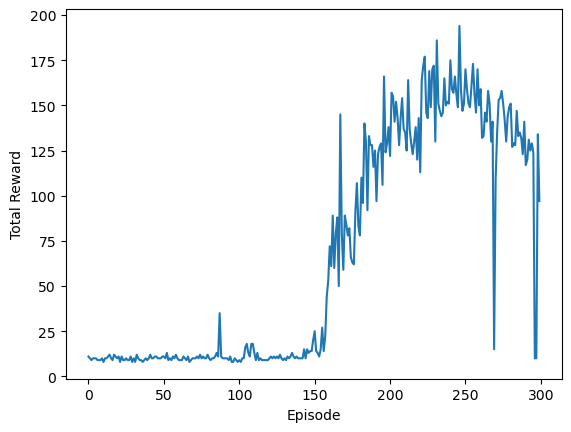

In [8]:
# [그림 8-8] 「카트 폴」에서 에피소드별 보상 총합의 추이
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.plot(range(len(reward_history)), reward_history)
plt.show()

In [10]:
# 학습이 끝난 에이전트에 탐욕 행동을 선택하도록 하여 플레이
agent.epsilon = 0  # 탐욕 정책(무작위로 행동할 확률 ε을 0로 설정)
state = env.reset()[0]
done = False
total_reward = 0

env.render() 에서 pygame install 에러 발생

In [12]:
!pip install pygame

   ---------------------------------------- 0.0/10.8 MB ? eta -:--:--
   ---------------------------------------- 0.1/10.8 MB 3.2 MB/s eta 0:00:04
   - -------------------------------------- 0.5/10.8 MB 6.4 MB/s eta 0:00:02
   --- ------------------------------------ 1.0/10.8 MB 7.9 MB/s eta 0:00:02
   ----- ---------------------------------- 1.5/10.8 MB 8.8 MB/s eta 0:00:02
   ------ --------------------------------- 1.8/10.8 MB 8.9 MB/s eta 0:00:02
   -------- ------------------------------- 2.3/10.8 MB 9.3 MB/s eta 0:00:01
   ---------- ----------------------------- 2.9/10.8 MB 9.6 MB/s eta 0:00:01
   ------------ --------------------------- 3.4/10.8 MB 9.9 MB/s eta 0:00:01
   -------------- ------------------------- 3.9/10.8 MB 10.1 MB/s eta 0:00:01
   ---------------- ----------------------- 4.5/10.8 MB 10.2 MB/s eta 0:00:01
   ------------------ --------------------- 5.0/10.8 MB 10.3 MB/s eta 0:00:01
   -------------------- ------------------- 5.5/10.8 MB 10.4 MB/s eta 0:00:01
  

In [13]:
while not done:
    action = agent.get_action(state)
    next_state, reward, terminated, truncated, info = env.step(action)
    done = terminated | truncated
    state = next_state
    total_reward += reward
    env.render()
print('Total Reward:', total_reward)

Total Reward: 126.0
